<div class="alert alert-block alert-success" style="font-size:30px">
[train] Pytorch:aux targets+weighted loss+thresholds
</div>


<div class="alert alert-block alert-info">
    <ul>
        <li>
            📌 This is a training part. For <b>inference</b> refer to: <a href="https://www.kaggle.com/code/vslaykovsky/infer-rsna-breast-cancer-effnetv2">[infer] RSNA Breast Cancer EffNetV2</a>
        </li>
        <li>
            📌 To run the notebook in non-interactive mode, <b>set Add-ons->Secrets->WANDB_API_KEY</b> secret key to the value of your <a href="https://wandb.ai/authorize">Wandb API key. </a>
        </li>
</div>



Some notes on the implementation:
* "cancer" targets are imbalanced, so we use weighted loss to counteract. See `CANCER_LOSS_WEIGHT` for details. Additionally, best values of thresholds are selected based on performance on evaluation set.
* [**Preprocessed dataset of 1024x512 png images**](https://www.kaggle.com/code/vslaykovsky/rsna-cut-off-empty-space-from-images) is used to train the model. This speeds up dataloader by ~10x with no performance degradation. Additionally empty space is removed from images
* Cross-entropy auxilliary targets are made of the following `train.csv` columns: `['site_id', 'laterality', 'view', 'implant', 'biopsy', 'invasive', 'BIRADS', 'density', 'difficult_negative_case', 'machine_id', 'age']`. Auxilliary targets help to learn combined *.CSV + *.PNG data distribution which helps to improve performance of the main classifier.


**UPDATE1**
* Migrated to `timm`
* Random augmentations with `timm.data.create_transform`
* Hyperparameter optimization with Wandb sweeps.

**UPDATE2**
* Larger images (only region of interest 1024x512)

<div class="alert alert-block alert-danger" style="text-align:center; font-size:16px;">
    Thanks for ▲upvoting▲ Kaggle notebooks when you click "Copy&Edit". This really motivates authors to produce more quality work.
</div>


<div class="alert alert-block alert-success" style="font-size:25px">
1. Imports, constants, dependencies
</div>

In [1]:

import gc
import os

# import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
from PIL import Image
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model, list_models
from timm.data import create_transform
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

import wandb

plt.rcParams['figure.figsize'] = (20, 5)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)

# Common
try:
    from kaggle_secrets import UserSecretsClient
    IS_KAGGLE = True
except:
    IS_KAGGLE = False

os.environ["WANDB_MODE"] = "online"
if os.environ["WANDB_MODE"] == "online":
    if IS_KAGGLE:
        os.environ['WANDB_API_KEY'] = UserSecretsClient().get_secret("WANDB_API_KEY")

        
RSNA_2022_PATH = '../input/rsna-breast-cancer-detection'
TRAIN_IMAGES_PATH = f'/kaggle/input/rsna-cut-off-empty-space-from-images'
MAX_TRAIN_BATCHES = 40000
MAX_EVAL_BATCHES = 400
MODELS_PATH = '/kaggle/input/wandb-models/models'
NUM_WORKERS = 8
PREDICT_MAX_BATCHES = 1e9
N_FOLDS = 5
FOLDS = np.array(os.environ.get('FOLDS', '0,1,2,3,4').split(',')).astype(int)
WANDB_SWEEP_PROJECT = 'rsna-breast-cancer-sweeps'
WANDB_PROJECT = 'RSNA-breast-cancer-v4'

CATEGORY_AUX_TARGETS = ['site_id', 'laterality', 'view', 'implant', 'biopsy', 'invasive', 'BIRADS', 'density', 'difficult_negative_case', 'machine_id', 'age']
TARGET = 'cancer'
ALL_FEAT = [TARGET] + CATEGORY_AUX_TARGETS

if not IS_KAGGLE:
    print('Running locally')
    RSNA_2022_PATH = 'data'
    TRAIN_IMAGES_PATH = 'data/roi1024/train_images'
    MODELS_PATH = 'models_roi_1024_v2'
    os.environ['WANDB_API_KEY'] = 'adc8abc0714ba20c3a534b907b9d6beec640f847'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Switchers
DEBUG = os.environ.get('DEBUG', 'true').lower() == 'true'
WANDB_SWEEP = False
TRAIN = False
CV = True

In [3]:
# Config

class Config:
    # These are optimal parameters collected from https://wandb.ai/vslaykovsky/rsna-breast-cancer-sweeps/sweeps/k281hlr9?workspace=user-vslaykovsky
    ONE_CYCLE = True
    ONE_CYCLE_PCT_START = 0.1
    ADAMW = False
    ADAMW_DECAY = 0.024
    # ONE_CYCLE_MAX_LR = float(os.environ.get('LR', '0.0008'))
    ONE_CYCLE_MAX_LR = float(os.environ.get('LR', '0.0004'))
    EPOCHS = int(os.environ.get('EPOCHS', 3))
    MODEL_TYPE = os.environ.get('MODEL', 'seresnext50_32x4d')
    DROPOUT = float(os.environ.get('DROPOUT', 0.0))
    AUG = os.environ.get('AUG', 'true').lower() == 'true'
    AUX_LOSS_WEIGHT = 94
    POSITIVE_TARGET_WEIGHT=20
    # BATCH_SIZE = 32
    BATCH_SIZE = 16
    AUTO_AUG_M = 10
    AUTO_AUG_N = 2
    TTA = False


WANDB_RUN_NAME = f'{Config.MODEL_TYPE}_lr{Config.ONE_CYCLE_MAX_LR}_ep{Config.EPOCHS}_bs{Config.BATCH_SIZE}_pw{Config.POSITIVE_TARGET_WEIGHT}_' +\
f'aux{Config.AUX_LOSS_WEIGHT}_{"adamw" if Config.ADAMW else "adam"}_{"aug" if Config.AUG else "noaug"}_drop{Config.DROPOUT}'
print('run', WANDB_RUN_NAME, 'folds', FOLDS)

run seresnext50_32x4d_lr0.0004_ep3_bs16_pw20_aux94_adam_aug_drop0.0 folds [0 1 2 3 4]


<div class="alert alert-block alert-success" style="font-size:25px">
2. Loading train/eval/test dataframes
</div>

1. Loading data from competition dataset folder `/kaggle/input/rsna-breast-cancer-detection/train.csv`
2. Adding `Splits` column to facilitate train/eval splits.

In [4]:
df_train = pd.read_csv(f'{RSNA_2022_PATH}/train.csv')
df_train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [5]:
df_train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [6]:
from sklearn.model_selection import StratifiedGroupKFold

split = StratifiedGroupKFold(N_FOLDS)
for k, (_, test_idx) in enumerate(split.split(df_train, df_train.cancer, groups=df_train.patient_id)):
    df_train.loc[test_idx, 'split'] = k
df_train.split = df_train.split.astype(int)
df_train.groupby('split').cancer.mean()

split
0    0.021127
1    0.021096
2    0.021205
3    0.021209
4    0.021203
Name: cancer, dtype: float64

In [7]:
df_train.age.fillna(df_train.age.mean(), inplace=True)

In [8]:
df_train['age'] = pd.qcut(df_train.age, 10, labels=range(10), retbins=False).astype(int)
df_train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,split
0,2,10006,462822612,L,CC,5,0,0,0,NaN,0,NaN,29,False,3
1,2,10006,1459541791,L,MLO,5,0,0,0,NaN,0,NaN,29,False,3
2,2,10006,1864590858,R,MLO,5,0,0,0,NaN,0,NaN,29,False,3
3,2,10006,1874946579,R,CC,5,0,0,0,NaN,0,NaN,29,False,3
4,2,10011,220375232,L,CC,3,0,0,0,0.0,0,NaN,21,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,0,0,0,0,1.0,0,C,49,False,2
54702,1,9989,63473691,L,MLO,5,0,0,0,NaN,0,C,216,False,0
54703,1,9989,1078943060,L,CC,5,0,0,0,NaN,0,C,216,False,0
54704,1,9989,398038886,R,MLO,5,0,0,0,0.0,0,C,216,True,0


In [9]:
df_train[CATEGORY_AUX_TARGETS] = df_train[CATEGORY_AUX_TARGETS].apply(LabelEncoder().fit_transform)

In [10]:
df_train[ALL_FEAT]

,cancer,site_id,laterality,view,implant,biopsy,invasive,BIRADS,density,difficult_negative_case,machine_id,age
0,0,1,0,1,0,0,0,3,4,0,1,5
1,0,1,0,5,0,0,0,3,4,0,1,5
2,0,1,1,5,0,0,0,3,4,0,1,5
3,0,1,1,1,0,0,0,3,4,0,1,5
4,0,1,0,1,0,0,0,0,4,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
54701,0,0,1,5,0,0,0,1,2,0,3,0
54702,0,0,0,5,0,0,0,3,2,0,9,5
54703,0,0,0,1,0,0,0,3,2,0,9,5
54704,0,0,1,5,0,0,0,0,2,1,9,5


<div class="alert alert-block alert-success" style="font-size:25px">
 3. Dataset class
</div>

`BreastCancerDataSet` class returns individual images. It uses a dataframe parameter `df` as a source of metadata to locate and load images from `path` folder. It accepts transforms parameter to apply transforms on images.

`get_transforms` generates a default set of transforms for an ImageNet-based model. Additionally with is_training=True it applies a set of random augmentations

(277, 1014)


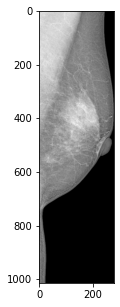

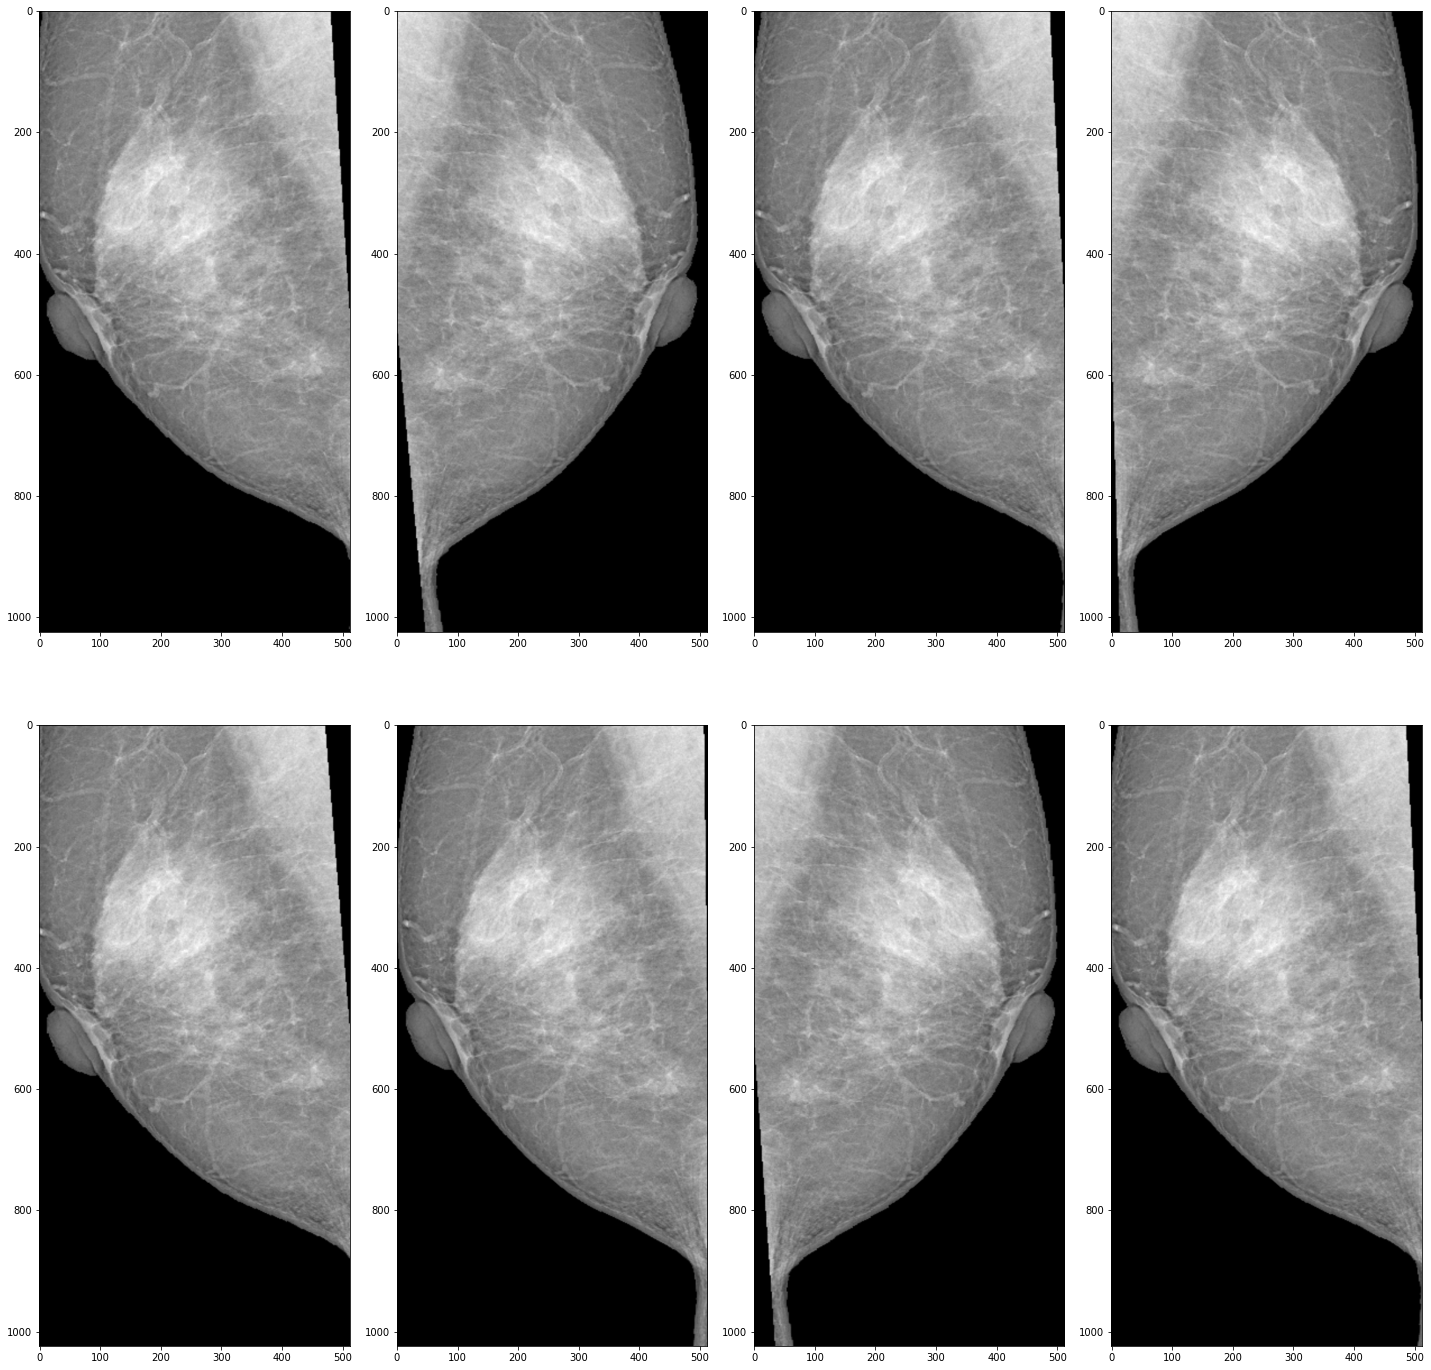

In [11]:
import torchvision

def get_transforms(aug=False):
    """
    # old transforms
    create_transform(
        (1024, 512), 
        mean=0.53, #(0.53, 0.53, 0.53),
        std=0.23, #(0.23, 0.23, 0.23),
        is_training=is_training, 
        auto_augment=f'rand-m{config.AUTO_AUG_M}-n{config.AUTO_AUG_N}'
    )
    """
    def transforms(img):
        img = img.convert('RGB')#.resize((512, 512))
        if aug:
            tfm = [
                torchvision.transforms.RandomHorizontalFlip(0.5),
                torchvision.transforms.RandomRotation(degrees=(-5, 5)), 
                torchvision.transforms.RandomResizedCrop((1024, 512), scale=(0.8, 1), ratio=(0.45, 0.55)) 
            ]
        else:
            tfm = [
                torchvision.transforms.RandomHorizontalFlip(0.5),
                torchvision.transforms.Resize((1024, 512))
            ]
        img = torchvision.transforms.Compose(tfm + [            
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=0.2179, std=0.0529),
            
        ])(img)
        return img

    return lambda img: transforms(img)

if DEBUG:
    tfm = get_transforms(aug=True)
    img = Image.open(f"{TRAIN_IMAGES_PATH}/10006/1459541791.png")
    print(img.size)
    plt.imshow(np.array(img), cmap='gray')
    plt.show()

    plt.figure(figsize=(20, 20))
    for i in range(8):
        v = tfm(img).permute(1, 2, 0)
        v -= v.min()
        v /= v.max()
        # plt.imshow(v)
        # break
        plt.subplot(2, 4, i + 1).imshow(v)
    plt.tight_layout()

In [12]:

class BreastCancerDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):

        path = f'{self.path}/{self.df.iloc[i].patient_id}/{self.df.iloc[i].image_id}.png'
        try:
            img = Image.open(path).convert('RGB')
        except Exception as ex:
            print(path, ex)
            return None

        if self.transforms is not None:
            img = self.transforms(img)


        if TARGET in self.df.columns:
            cancer_target = torch.as_tensor(self.df.iloc[i].cancer)
            cat_aux_targets = torch.as_tensor(self.df.iloc[i][CATEGORY_AUX_TARGETS])
            return img, cancer_target, cat_aux_targets

        return img

    def __len__(self):
        return len(self.df)

ds_train = BreastCancerDataSet(df_train, TRAIN_IMAGES_PATH, get_transforms(aug=True))
if DEBUG:
    X, y_cancer, y_aux = ds_train[42]
    print(X.shape, y_cancer.shape, y_aux.shape)

torch.Size([3, 1024, 512]) torch.Size([]) torch.Size([11])


<div class="alert alert-block alert-success" style="font-size:25px">
    3. Model
</div>

We create a backbone with `timm.create_model`. The backbone is strip of classification layer (num_classes=0). We create multiple linear heads (see self.nn_cancer, self.nn_aux). nn_aux is used to predict other columns of train.csv


In [13]:
class BreastCancerModel(torch.nn.Module):
    def __init__(self, aux_classes, model_type=Config.MODEL_TYPE, dropout=0.):
        super().__init__()
        self.model = create_model(model_type, pretrained=True, num_classes=0, drop_rate=dropout)

        self.backbone_dim = self.model(torch.randn(1, 3, 512, 512)).shape[-1]

        self.nn_cancer = torch.nn.Sequential(
            torch.nn.Linear(self.backbone_dim, 1),
        )
        self.nn_aux = torch.nn.ModuleList([
            torch.nn.Linear(self.backbone_dim, n) for n in aux_classes
        ])

    def forward(self, x):
        # returns logits
        x = self.model(x)

        cancer = self.nn_cancer(x).squeeze()
        aux = []
        for nn in self.nn_aux:
            aux.append(nn(x).squeeze())
        return cancer, aux

    def predict(self, x):
        cancer, aux = self.forward(x)
        sigaux = []
        for a in aux:
            sigaux.append(torch.softmax(a, dim=-1))
        return torch.sigmoid(cancer), sigaux

AUX_TARGET_NCLASSES = df_train[CATEGORY_AUX_TARGETS].max() + 1

if DEBUG:
    with torch.no_grad():
        model = BreastCancerModel(AUX_TARGET_NCLASSES, model_type='seresnext50_32x4d')
        pred, aux = model.predict(torch.randn(2, 3, 512, 512))
        print('seresnext', pred.shape, len(aux))

        model = BreastCancerModel(AUX_TARGET_NCLASSES, model_type='efficientnet_b4')
        pred, aux = model.predict(torch.randn(2, 3, 512, 512))
        print('efficientnet_b4', pred.shape, len(aux))

    del model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth" to /root/.cache/torch/hub/checkpoints/seresnext50_32x4d_racm-a304a460.pth


seresnext torch.Size([2]) 11


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_ra2_320-7eb33cd5.pth


efficientnet_b4 torch.Size([2]) 11


<div class="alert alert-block alert-success" style="font-size:25px">
    4. Train: training/evaluation loop
</div>

* We use low precision to speed up training (see `autocast`)
* We use pF1 target metric (see `pfbeta`). After every epoch we calculate the best value of the metric by search for an optimal threshold.

In [14]:
def save_model(name, model, thres, model_type):
    torch.save({'model': model.state_dict(), 'threshold': thres, 'model_type': model_type}, f'{name}')

In [15]:
def load_model(name, dir='.', model=None):
    data = torch.load(os.path.join(dir, f'{name}'), map_location=DEVICE)
    if model is None:
        model = BreastCancerModel(AUX_TARGET_NCLASSES, data['model_type'])
    model.load_state_dict(data['model'])
    return model, data['threshold'], data['model_type']


if DEBUG:
    # quick test
    model = torch.nn.Linear(2, 1)
    save_model('testmodel', model, thres=0.123, model_type='abc')

    model1, thres, model_type = load_model('testmodel', model=torch.nn.Linear(2, 1))
    assert torch.all(
        next(iter(model1.parameters())) == next(iter(model.parameters()))
    ).item(), "Loading/saving is inconsistent!"
    print(thres, model_type)

0.123 abc


In [16]:
def pfbeta(labels, predictions, beta=1.):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / max(y_true_count, 1)  # avoid / 0
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

def optimal_f1(labels, predictions):
    thres = np.linspace(0, 1, 101)
    f1s = [pfbeta(labels, predictions > thr) for thr in thres]
    idx = np.argmax(f1s)
    return f1s[idx], thres[idx]

def evaluate_model(model: BreastCancerModel, ds, max_batches=PREDICT_MAX_BATCHES, shuffle=False, config=Config):
    torch.manual_seed(42)
    model = model.to(DEVICE)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=config.BATCH_SIZE, shuffle=shuffle, num_workers=NUM_WORKERS, pin_memory=False)
    pred_cancer = []
    with torch.no_grad():
        
        model.eval()
        cancer_losses = []
        aux_losses = []
        losses = []
        targets = []
        with tqdm(dl_test, desc='Eval', mininterval=30) as progress:
            for i, (X, y_cancer, y_aux) in enumerate(progress):
                with autocast(enabled=True):
                    y_aux = y_aux.to(DEVICE)
                    X = X.to(DEVICE)
                    y_cancer_pred, aux_pred = model.forward(X)
                    if config.TTA:
                        y_cancer_pred2, aux_pred2 = model.forward(torch.flip(X, dims=[-1])) # horizontal mirror
                        y_cancer_pred = (y_cancer_pred + y_cancer_pred2) / 2
                        aux_pred = [(v1 + v2) / 2 for v1, v2 in zip(aux_pred, aux_pred2)]

                    cancer_loss = torch.nn.functional.binary_cross_entropy_with_logits(
                        y_cancer_pred, 
                        y_cancer.to(float).to(DEVICE),
                        pos_weight=torch.tensor([config.POSITIVE_TARGET_WEIGHT]).to(DEVICE)
                    ).item()
                    aux_loss = torch.mean(torch.stack([torch.nn.functional.cross_entropy(aux_pred[i], y_aux[:, i]) for i in range(y_aux.shape[-1])])).item()
                    pred_cancer.append(torch.sigmoid(y_cancer_pred))
                    cancer_losses.append(cancer_loss)
                    aux_losses.append(aux_loss)
                    losses.append(cancer_loss + config.AUX_LOSS_WEIGHT * aux_loss)
                    targets.append(y_cancer.cpu().numpy())
                if i >= max_batches:
                    break
        targets = np.concatenate(targets)
        pred = torch.concat(pred_cancer).cpu().numpy()
        pf1, thres = optimal_f1(targets, pred)
        return np.mean(cancer_losses), (pf1, thres), pred, np.mean(losses), np.mean(aux_losses)


# quick test
if DEBUG:

    m = BreastCancerModel(AUX_TARGET_NCLASSES)
    closs, f1, pred, loss, aloss = evaluate_model(m, ds_train, max_batches=2)
    del m
    closs, f1, pred.shape, loss, aloss

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Eval:   0%|          | 2/3420 [00:14<6:48:59,  7.18s/it]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


In [17]:
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [18]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if len(param.shape) == 1 or np.any([v in name.lower()  for v in skip_list]):
            # print(name, 'no decay')
            no_decay.append(param)
        else:
            # print(name, 'decay')
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

In [19]:
def train_model(ds_train, ds_eval, logger, name, config=Config, do_save_model=True):
    torch.manual_seed(42)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

    model = BreastCancerModel(AUX_TARGET_NCLASSES, config.MODEL_TYPE, config.DROPOUT).to(DEVICE)

    if config.ADAMW:
        optim = torch.optim.AdamW(add_weight_decay(model, weight_decay=config.ADAMW_DECAY, skip_list=['bias']), lr=config.ONE_CYCLE_MAX_LR, betas=(0.9, 0.999), weight_decay=config.ADAMW_DECAY)
    else:
        optim = torch.optim.Adam(model.parameters())


    scheduler = None
    if config.ONE_CYCLE:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=config.ONE_CYCLE_MAX_LR, epochs=config.EPOCHS,
                                                        steps_per_epoch=len(dl_train),
                                                        pct_start=config.ONE_CYCLE_PCT_START)
        
    

    scaler = GradScaler()
    best_eval_score = 0
    for epoch in tqdm(range(config.EPOCHS), desc='Epoch'):

        model.train()
        with tqdm(dl_train, desc='Train', mininterval=30) as train_progress:
            for batch_idx, (X, y_cancer, y_aux) in enumerate(train_progress):
                y_aux = y_aux.to(DEVICE)

                optim.zero_grad()
                # Using mixed precision training
                with autocast():
                    y_cancer_pred, aux_pred = model.forward(X.to(DEVICE))
                    cancer_loss = torch.nn.functional.binary_cross_entropy_with_logits(
                        y_cancer_pred,
                        y_cancer.to(float).to(DEVICE),
                        pos_weight=torch.tensor([config.POSITIVE_TARGET_WEIGHT]).to(DEVICE)
                    )
                    aux_loss = torch.mean(torch.stack([torch.nn.functional.cross_entropy(aux_pred[i], y_aux[:, i]) for i in range(y_aux.shape[-1])]))
                    loss = cancer_loss + config.AUX_LOSS_WEIGHT * aux_loss
                    if np.isinf(loss.item()) or np.isnan(loss.item()):
                        print(f'Bad loss, skipping the batch {batch_idx}')
                        del loss, cancer_loss, y_cancer_pred
                        gc_collect()
                        continue

                # scaler is needed to prevent "gradient underflow"
                scaler.scale(loss).backward()
                scaler.step(optim)
                if scheduler is not None:
                    scheduler.step()
                    
                scaler.update()

                lr = scheduler.get_last_lr()[0] if scheduler else config.ONE_CYCLE_MAX_LR
                logger.log({'loss': (loss.item()),
                            'cancer_loss': cancer_loss.item(),
                            'aux_loss': aux_loss.item(),
                            'lr': lr,
                            'epoch': epoch})


        if ds_eval is not None and MAX_EVAL_BATCHES > 0:
            cancer_loss, (f1, thres), _, loss, aux_loss = evaluate_model(
                model, ds_eval, max_batches=MAX_EVAL_BATCHES, shuffle=False, config=config)

            if f1 > best_eval_score:
                best_eval_score = f1
                if do_save_model:
                    save_model(name, model, thres, config.MODEL_TYPE)
                    art = wandb.Artifact("rsna-breast-cancer", type="model")
                    art.add_file(f'{name}')
                    logger.log_artifact(art)

            logger.log(
                {
                    'eval_cancer_loss': cancer_loss,
                    'eval_f1': f1,
                    'max_eval_f1': best_eval_score,
                    'eval_f1_thres': thres,
                    'eval_loss': loss,
                    'eval_aux_loss': aux_loss,
                    'epoch': epoch
                }
            )

    return model


# N-fold models. Can be used to estimate accurate CV score and in ensembled submissions.
if TRAIN:
    for fold in FOLDS:
        name = f'{WANDB_RUN_NAME}-f{fold}'
        with wandb.init(project=WANDB_PROJECT, name=name, group=WANDB_RUN_NAME) as run:
            gc_collect()
            ds_train = BreastCancerDataSet(df_train.query('split != @fold'), TRAIN_IMAGES_PATH, get_transforms(aug=Config.AUG))
            ds_eval = BreastCancerDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, get_transforms(aug=False))
            train_model(ds_train, ds_eval, run, f'model-f{fold}')

In [20]:
%wandb vslaykovsky/RSNA-breast-cancer-v4 -h 1000

<div class="alert alert-block alert-success" style="font-size:25px">
    5. Wandb Sweeps
</div>


Enable `WANDB_SEEP` to use the feature.

1. Run the cell once to generate SWEEP_ID
2. Set the SWEEP_ID environment variable to run the agent.
3. Run one or more agents to start hyperparameter optimization.

In [21]:
#  %env SWEEP_ID=tfi5ayrd

In [22]:

if WANDB_SWEEP:
    sweep_id = os.environ.get('SWEEP_ID')
    print('wandb sweep ', sweep_id)

    if sweep_id is None:
        """
        First run. Generate sweep_id.
        """
        sweep_id = wandb.sweep(sweep={
            'method': 'bayes',
            'name': 'rsna-sweep',
            'metric': {'goal': 'maximize', 'name': 'max_eval_f1'},
            'parameters':
                {
                    'ONE_CYCLE': {'values': [True, False]},
                    'ONE_CYCLE_PCT_START': {'values': [0.1]},
                    'ADAMW': {'values': [True, False]},
                    'ADAMW_DECAY': {'min': 0.001, 'max': 0.1, 'distribution': 'log_uniform_values'},
                    'ONE_CYCLE_MAX_LR': {'min': 1e-5, 'max': 1e-3, 'distribution': 'log_uniform_values'},
                    'EPOCHS': {'min': 1, 'max': 12, 'distribution': 'q_log_uniform_values'},
                    'MODEL_TYPE': {'values': ['resnext50_32x4d', 'efficientnetv2_rw_s', 'seresnext50_32x4d', 'inception_v4', 'efficientnet_b4']},
                    'DROPOUT': {'values': [0., 0.2]},
                    'AUG': {'values': [True, False]},
                    'AUX_LOSS_WEIGHT': {'min': 0.01, 'max': 100., 'distribution': 'log_uniform_values'},
                    'POSITIVE_TARGET_WEIGHT': {'min': 1., 'max': 60., 'distribution': 'uniform'},
                    'BATCH_SIZE': {'values': [32]},
                    'AUTO_AUG_M': {'min': 1, 'max': 20, 'distribution': 'q_log_uniform_values'},
                    'AUTO_AUG_N': {'min': 1, 'max': 6, 'distribution': 'q_uniform'},
                    'TTA': {'values': [False]},
                }
        }, project=WANDB_SWEEP_PROJECT)
        print('Generated sweep id', sweep_id)
    else:
        """
        Agent run. Use sweep_id generated above to produce (semi)-random hyperparameters run.config
        """
        def wandb_callback():
            with wandb.init() as run:
                print('params', run.config)
                fold = 0
                ds_train = BreastCancerDataSet(df_train.query('split != @fold'), TRAIN_IMAGES_PATH, get_transforms(aug=run.config.AUG))
                ds_eval = BreastCancerDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, get_transforms(aug=False))
                train_model(ds_train, ds_eval, run, f'model-f{fold}', config=run.config, do_save_model=False)


        # Start sweep job.
        wandb.agent(sweep_id, project=WANDB_SWEEP_PROJECT, function=wandb_callback, count=100000)

In [23]:
%wandb -h 1800 vslaykovsky/rsna-breast-cancer-sweeps/sweeps/k281hlr9

<div class="alert alert-block alert-success" style="font-size:25px">
    6. Cross-validation
</div>

In [24]:

def gen_predictions(models, df_train):
    df_train_predictions = []
    with tqdm(enumerate(models), total=len(models), desc='Folds') as progress:
        for fold, model in progress:
            if model is not None:
                ds_eval = BreastCancerDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, get_transforms(aug=False))

                cancer_loss, (f1, thres), pred_cancer = evaluate_model(model, ds_eval, PREDICT_MAX_BATCHES)[:3]
                progress.set_description(f'Eval fold:{fold} pF1:{f1:.02f}')
                df_pred = pd.DataFrame(data=pred_cancer,
                                              columns=['cancer_pred_proba'])
                df_pred['cancer_pred'] = df_pred.cancer_pred_proba > thres

                df = pd.concat(
                    [df_train.query('split == @fold').reset_index(drop=True), df_pred],
                    axis=1
                ).sort_values(['patient_id', 'image_id'])
                df_train_predictions.append(df)
    df_train_predictions = pd.concat(df_train_predictions)
    return df_train_predictions

if CV:
    models = [load_model(model, MODELS_PATH, BreastCancerModel(AUX_TARGET_NCLASSES))[0] for model in sorted(os.listdir(MODELS_PATH))]
    df_pred = gen_predictions(models, df_train)
    df_pred.to_csv('train_predictions.csv', index=False)
    !head train_predictions.csv

Eval: 100%|██████████| 684/684 [06:21<00:00,  1.79it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
Eval fold:1 pF1:0.27: 100%|██████████| 2/2 [12:55<00:00, 387.90s/it]


site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,split,cancer_pred_proba,cancer_pred
0,25,822390278,1,1,6,0,0,0,1,0,1,3,0,0,0.6284,False
0,25,1442180348,0,5,6,0,0,0,1,0,1,3,0,0,0.309,False
0,25,1723979573,1,5,6,0,0,0,1,0,1,3,0,0,0.3047,False
0,25,1789648218,0,1,6,0,0,0,1,0,1,3,0,0,0.528,False
0,25,1962456803,1,5,6,0,0,0,1,0,1,3,0,0,0.3123,False
0,25,1997933901,1,1,6,0,0,0,1,0,1,3,0,0,0.4265,False
0,49,323049527,1,1,2,0,0,0,1,0,1,3,0,0,0.01785,False
0,49,373605482,0,1,2,0,0,0,1,0,1,3,0,0,0.03854,False
0,49,872677361,1,5,2,0,0,0,1,0,1,3,0,0,0.01799,False


In [25]:
if CV:
    df_pred = pd.read_csv('train_predictions.csv')
    print('F1 CV score (multiple thresholds):', sklearn.metrics.f1_score(df_pred.cancer, df_pred.cancer_pred))    
    df_pred = df_pred.groupby(['patient_id', 'laterality']).agg(
        cancer_max=('cancer_pred_proba', 'max'), cancer_mean=('cancer_pred_proba', 'mean'), cancer=('cancer', 'max')
    )
    print('pF1 CV score. Mean aggregation, single threshold:', optimal_f1(df_pred.cancer.values, df_pred.cancer_mean.values))
    print('pF1 CV score. Max aggregation, single threshold:', optimal_f1(df_pred.cancer.values, df_pred.cancer_max.values))

F1 CV score (multiple thresholds): 0.27242524916943517


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


pF1 CV score. Mean aggregation, single threshold: (0.3271767810026386, 0.64)
pF1 CV score. Max aggregation, single threshold: (0.3071017274472169, 0.8200000000000001)


In [26]:
if IS_KAGGLE:
    !rm -rf wandb
    pass

<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>